In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [27]:
# Read data set
df = pd.read_csv('data/energydata_complete.csv',
                 index_col=0,
                 parse_dates=True,
                 dayfirst=True)

df = df.sort_index()
origin_df = df.copy()

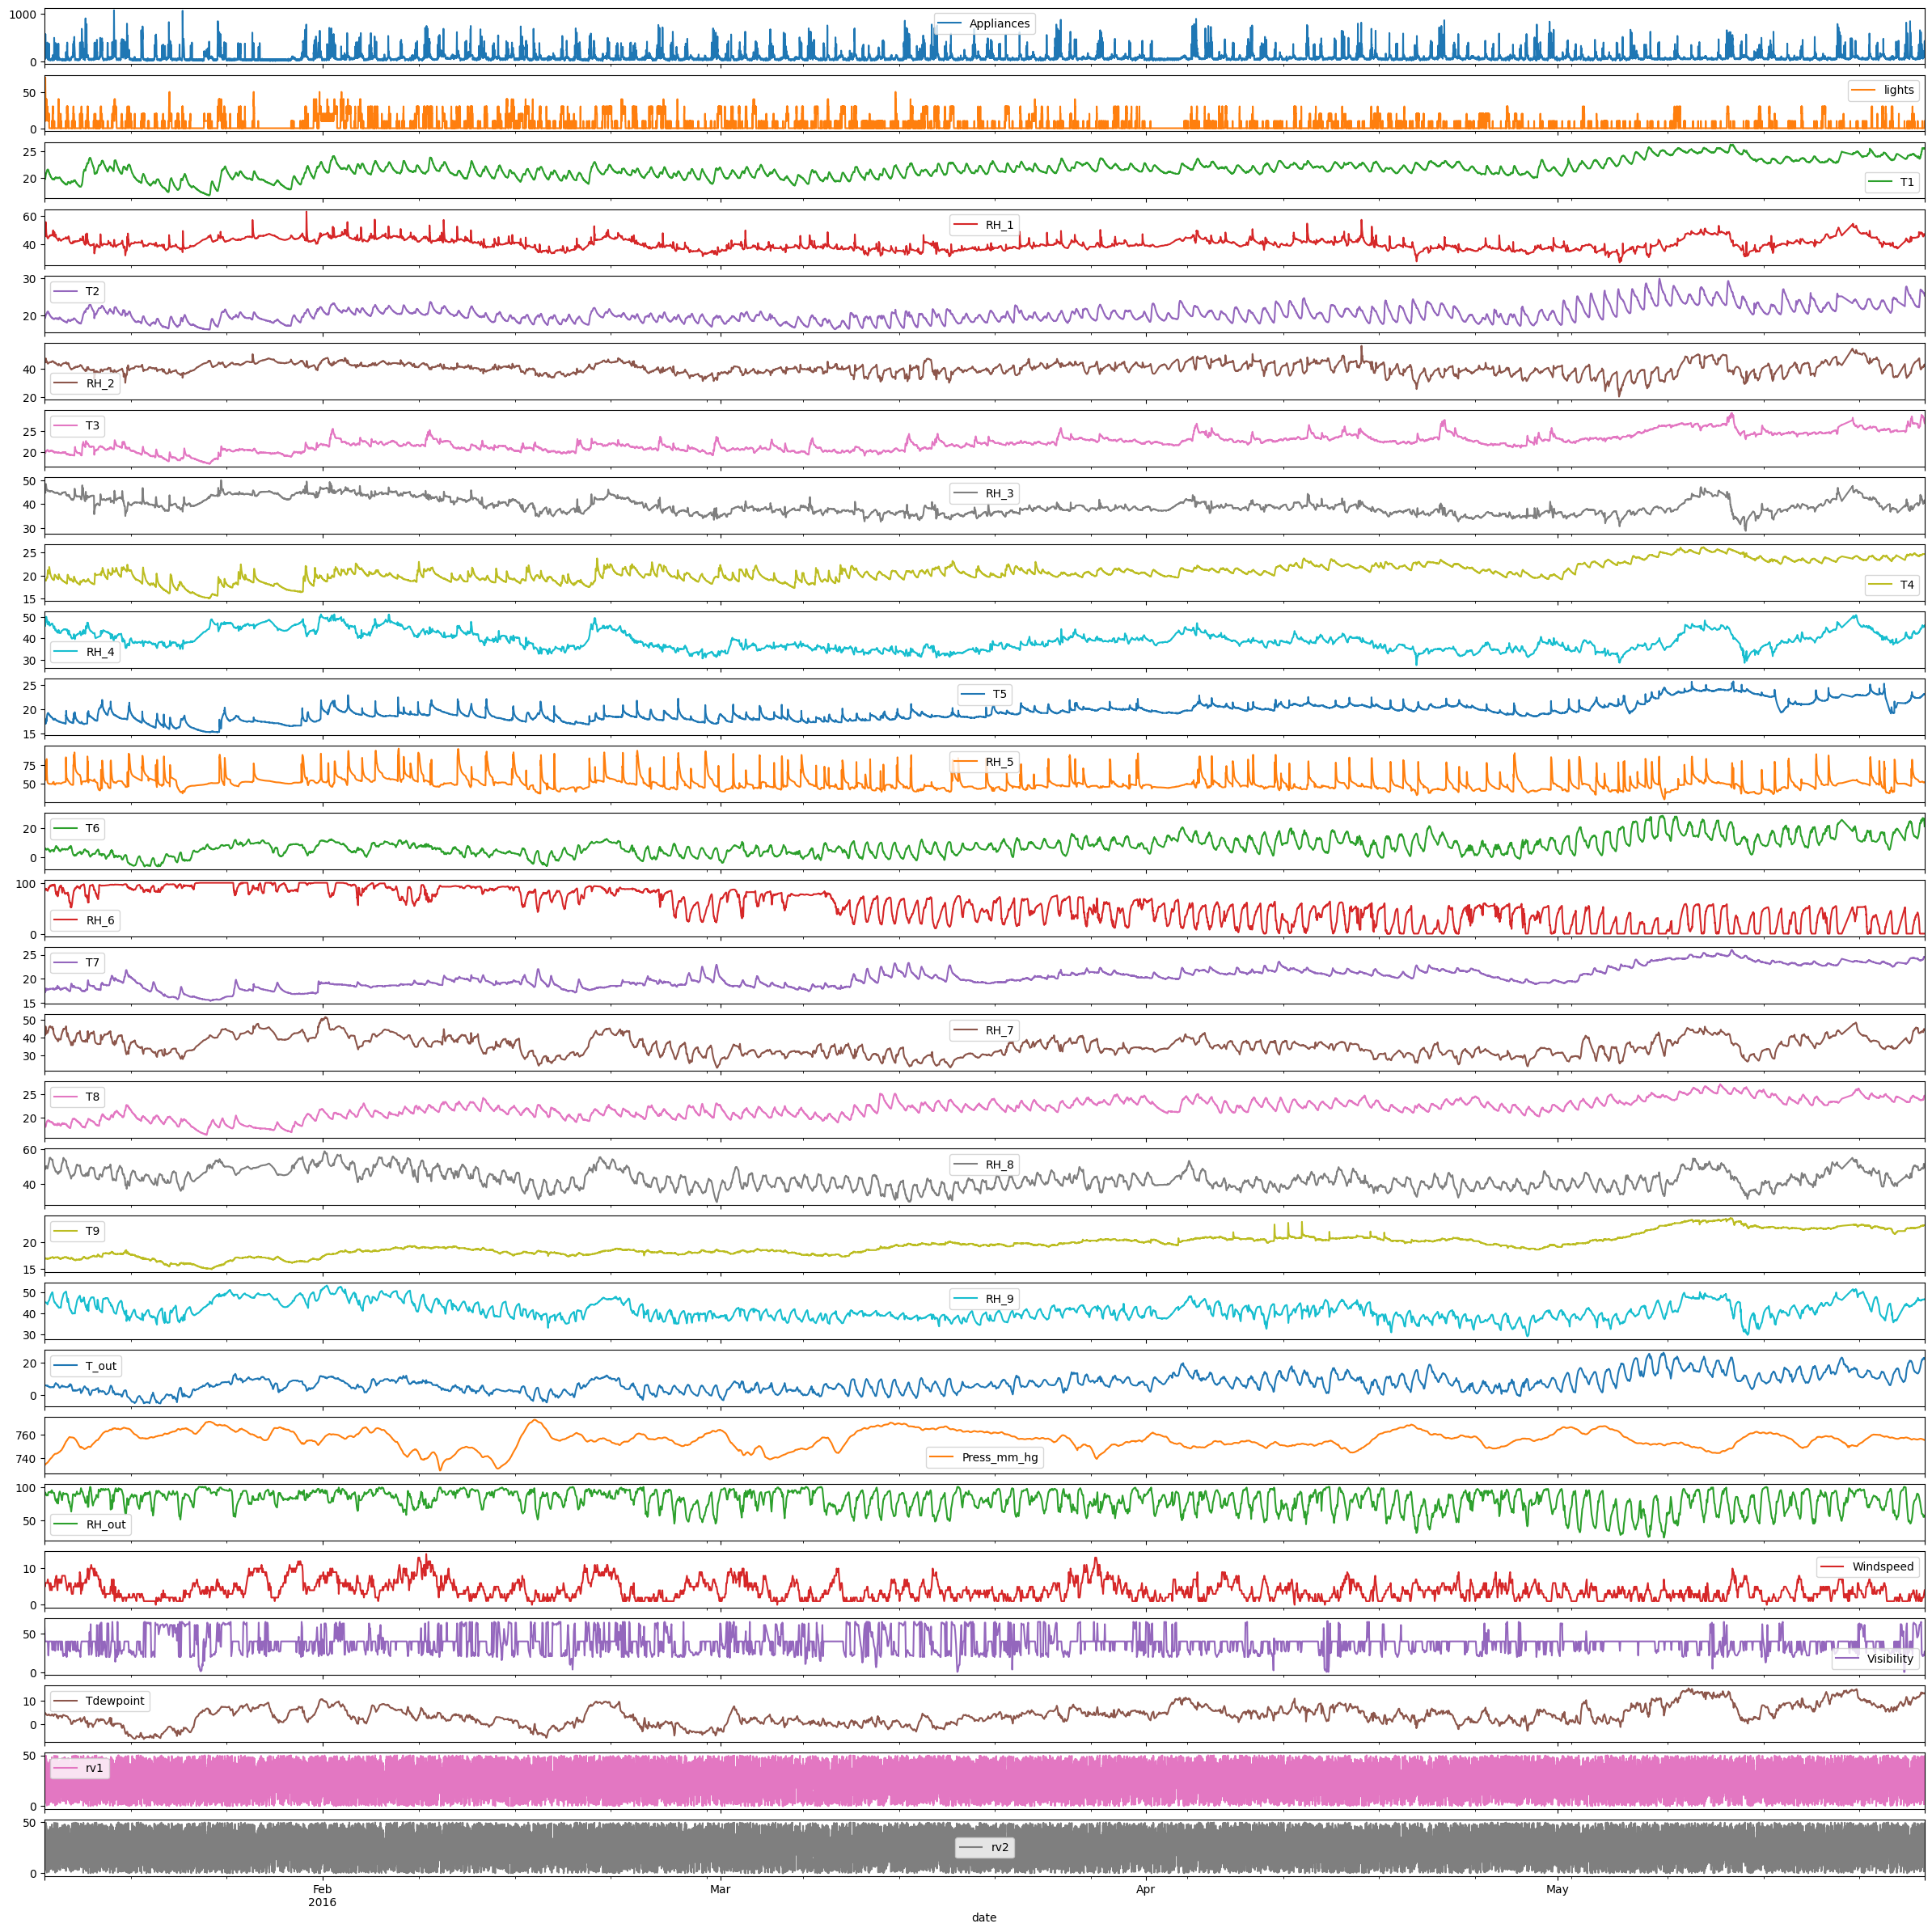

In [28]:
df.plot(figsize=(30, 30), subplots=True)
plt.show()

<AxesSubplot:xlabel='date'>

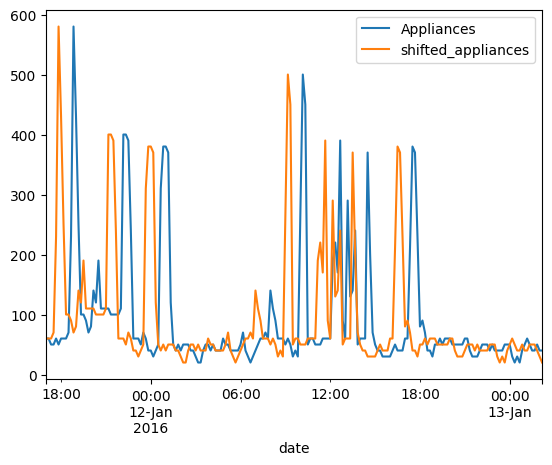

In [29]:
# 1時間ごとの相関
lag_column = 'shifted_appliances'
df[lag_column] = df['Appliances'].shift(-6) # データ間隔10minのデータを1時間分シフトする
df = df.dropna(axis=0)
df['Appliances'].iloc[:200].plot(legend=['Appliances'])
df[lag_column].iloc[:200].plot(legend=[lag_column])

In [30]:
# 訓練データの分割
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_df, valid_df = train_test_split(train_df, test_size=0.3, shuffle=False)

target = 'shifted_appliances'
def split_target(df, target):
    return df.drop(target, axis=1), df.loc[:, [target]]

# 正規化処理
xscl = StandardScaler()
yscl = StandardScaler()

# 説明変数と目的変数に分割
xtr, ytr = split_target(train_df, target)
xvl, yvl = split_target(valid_df, target)

# 学習データの平均分散の保存と正規化の実行
nxtr = xscl.fit_transform(xtr)
nytr = yscl.fit_transform(ytr)

# 学習の平均・標準偏差でバリデーションを正規化
nxvl = xscl.transform(xvl)
nyvl = yscl.transform(yvl).ravel()

# テストデータを出力
xts, yts = split_target(test_df, target)
nxts = xscl.transform(xts)

In [31]:
# モデルの学習と予測
model = LinearRegression()

# 説明変数nxtrから目的変数nxvlを学習
model.fit(nxtr, nytr)
# バリデーション
nypred_val = model.predict(nxvl)

# 正規化を戻して平均絶対誤差(MAE)を計算
predy_val = yscl.inverse_transform(pd.DataFrame(nypred_val, index=valid_df.index))
print('Validation MAE: ', mean_absolute_error(yvl, predy_val))

Validation MAE:  54.754392226319425


In [32]:
# 学習と評価を行う関数
def train_model(model, train_df, valid_df, test_df):
    # データとモデルから学習済みモデル、予測結果を返す関数
    
    # 正規化処理
    xscl = StandardScaler()
    yscl = StandardScaler()
    
    # 説明変数と目的変数に分割
    xtr, ytr = split_target(train_df, target)
    xvl, yvl = split_target(valid_df, target)
    
    # 正規化の実行
    nxtr = xscl.fit_transform(xtr)
    nytr = yscl.fit_transform(ytr).ravel()
    
    # 学習の平均・標準偏差でバリデーションを正規化
    nxvl = xscl.transform(xvl)
    nyvl = yscl.transform(yvl).ravel()
    
    # モデルの学習と予測
    model.fit(nxtr, nytr)
    nypred_val = model.predict(nxvl)
    
    # 正規化を戻して平均絶対誤差(MAE)を計算
    predy_val = yscl.inverse_transform(pd.DataFrame(nypred_val, index=valid_df.index))
    print('Validation MAE: ', mean_absolute_error(yvl, predy_val))
    
    # テストデータ出力
    xts, yts = split_target(test_df, target)
    nxts = xscl.transform(xts)
    
    npredy = model.predict(nxts)
    predy_test = yscl.inverse_transform(pd.DataFrame(npredy))
    
    return dict(model=model, predy_val = pd.DataFrame(predy_val, index=valid_df.index),
                predy_test = pd.DataFrame(predy_test, index=test_df.index))

In [33]:
result = dict()

# LinearRegression
result['lr'] = train_model(LinearRegression(), train_df, valid_df, test_df)

# Lasso
result['lasso'] = train_model(Lasso(alpha=0.01), train_df, valid_df, test_df)

# Ridge
result['ridge'] = train_model(Ridge(alpha=0.01), train_df, valid_df, test_df)

# ElasticNet
result['elas'] = train_model(ElasticNet(alpha=0.01), train_df, valid_df, test_df)

Validation MAE:  54.754392226319425
Validation MAE:  54.01870092754537
Validation MAE:  54.75426926529239
Validation MAE:  54.456648250509396


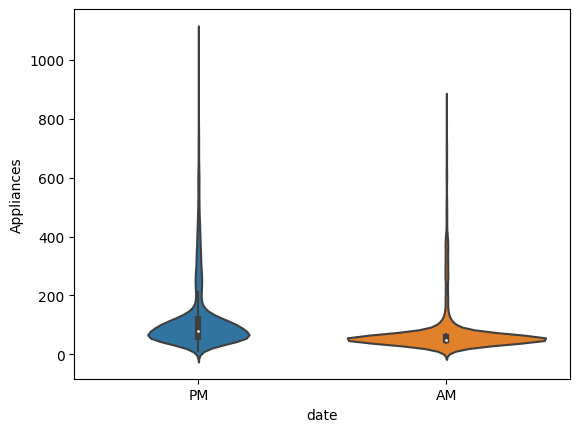

In [34]:
sns.violinplot(df, x=df.index.strftime('%p'), y=df['Appliances'])
plt.show()

In [35]:
df['am/pm'] = df.index.strftime('%p')
df_time = pd.get_dummies(df, columns=['am/pm'], drop_first=True)

train_df, test_df = train_test_split(df_time, test_size=0.2, shuffle=False)
train_df, valid_df = train_test_split(train_df, test_size=0.3, shuffle=False)
# LinearRegression
result['lr'] = train_model(LinearRegression(), train_df, valid_df, test_df)
# Lasso
result['lasso'] = train_model(Lasso(alpha=0.01), train_df, valid_df, test_df)
# Ridge
result['ridge'] = train_model(Ridge(alpha=0.01), train_df, valid_df, test_df)
# ElasticNet
result['elas'] = train_model(ElasticNet(alpha=0.01), train_df, valid_df, test_df)

c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Validation MAE:  54.25526660537905
Validation MAE:  53.69488069559687
Validation MAE:  54.255151059814985
Validation MAE:  54.20121739162983


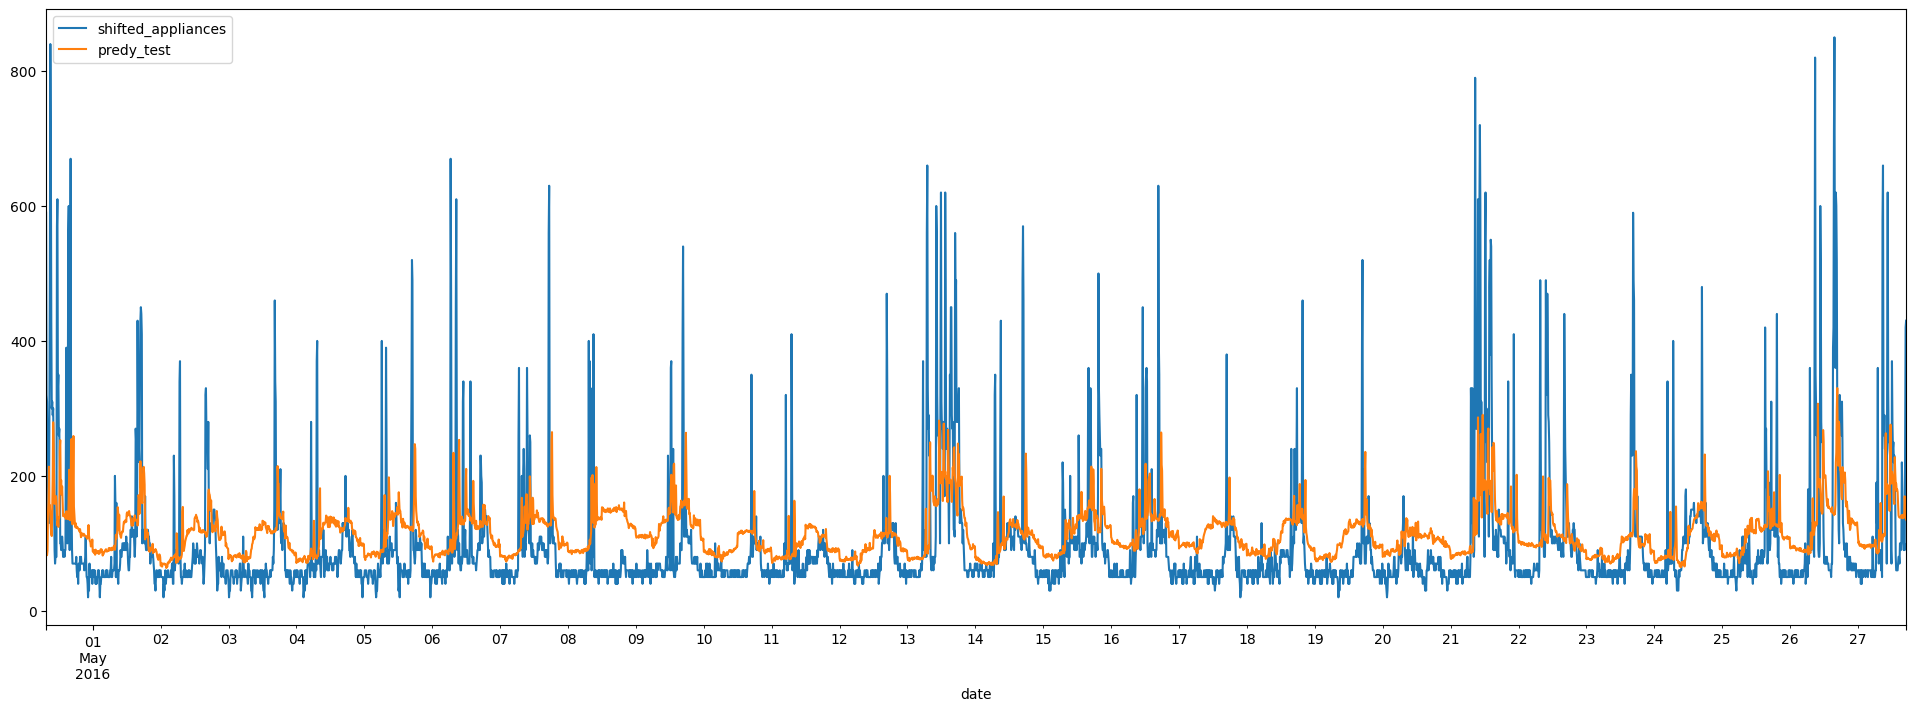

In [36]:
fig, ax = plt.subplots()
test_df['shifted_appliances'].plot(figsize=(24, 8), ax=ax)
result['lasso']['predy_test'].plot(figsize=(24, 8), ax=ax)
plt.legend(['shifted_appliances', 'predy_test'])
plt.show()